In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import random

#シード値の固定
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from vessel_MAE_new import vessel_MAE_new

In [3]:
net = vessel_MAE_new()

In [14]:
input=torch.randn(16,1,48,512)
label=torch.randn(16,1)
output=net(input,label)
print(output)

(tensor(3.3001, grad_fn=<MeanBackward0>), tensor(1.7366, grad_fn=<DivBackward0>))


In [2]:
data_path = "/root/work/data/2021"
result_path = "/root/work/result/MAE/mim_loss"

In [3]:
transform = transforms.Resize((48,512))

x_data=[]

for i in range(1,302):
    img=np.load(file=data_path+"/deck_depth_map/data/hull"+str(i)+".npy")
    img=torch.tensor(img).reshape(1,48,521)
    img=transform(img)
    img=np.array(img[0])
    x_data.append(img)

x_data=np.array(x_data)
x_data = np.delete(x_data, range(117, 119), axis=0)
x_data=np.flip(x_data,axis=2)
x_data=np.array(x_data).reshape(299,1,48,512)
x_data=torch.tensor(x_data)

X_MAX = x_data.max()
x_data /= X_MAX

y = np.genfromtxt(data_path + "/hist_naked.dat", dtype=float, skip_header=1)
y = np.delete(y, range(117, 119), axis=0)
y_data=y[:,4:5]

In [7]:
x_data[0][0].shape

torch.Size([48, 512])

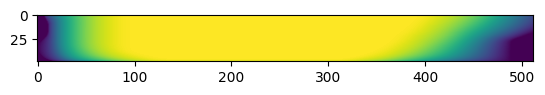

In [9]:
plt.imshow(x_data[0][0])
plt.show()

In [6]:
class HullDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [7]:
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold


batch_size=16

data=torch.tensor(x_data).float().clone().detach()
targets=torch.tensor(y_data).float().clone().detach()

dataset=HullDataset(data,targets)

kfold=KFold(n_splits=5,shuffle=True,random_state=0)

train_loaders=[]
val_loaders=[]

for train_index,val_index in kfold.split(dataset):
    train_dataset=Subset(dataset,train_index)
    val_dataset=Subset(dataset,val_index)

    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

/tmp/ipykernel_468841/3041624954.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data=torch.tensor(x_data).float().clone().detach()


In [8]:
from vessel_MAE_decls import vessel_MAE_decls
import torch

net = vessel_MAE_decls()

weight_file = '/root/work/result/MAE/decls_sche/model0.pth'
weights = torch.load(weight_file)
net.load_state_dict(weights)

<All keys matched successfully>

In [9]:
import torch
import torch.nn as nn

class NewModel(nn.Module):
    def __init__(self, patch_embed, decoder_blocks, fom_mlp):
        super(NewModel, self).__init__()
        self.patch_embed = patch_embed
        self.decoder_blocks = decoder_blocks
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, 48 + 1, 512))
        self.fom_mlp = fom_mlp

    def forward(self, x):
        # モデルの処理を定義する
        x = self.patch_embed(x)
        x = torch.cat([x[:, :1, :], x], dim=1) 
        x = x + self.decoder_pos_embed

        for block in self.decoder_blocks:
            x = block(x)
        x = x[:, 0, :]
        x = x.squeeze(1)
        x = self.fom_mlp(x)
        return x

# 新たなモデルのインスタンスを作成
new_model = NewModel(net.patch_embed, net.decoder_blocks, net.fom_mlp)



In [10]:
train_loader = train_loaders[0]
val_loader = val_loaders[0]

In [11]:
for inputs, targets in train_loader:
    pred=new_model(inputs)
    loss_train = loss(pred, targets)
    print(loss_train.item())

NameError: name 'loss' is not defined

In [ ]:
new_model.eval()
loss = nn.MSELoss()

for inputs, targets in val_loader:
    pred=new_model(inputs)
    loss_val = loss(pred, targets)
    print(loss_val.item())



734.1527099609375
793.0654907226562
875.1021728515625
869.3875122070312
